In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob

mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [2]:
model_name = "v13_mustachecleaning"
model_dir = "../models/"+model_name
det = "EB"
model_version = 2
numpy_version = 16
cols = ["seed_eta", "seed_phi", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
        "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
        "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth"]

os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [3]:
files_ele = f"/storage/ECAL/training_data/electrons/numpy_v{numpy_version}/training/"
files_gamma = f"/storage/ECAL/training_data/gammas/numpy_v{numpy_version}/training/"

In [4]:
datas_ele = []

i = 0
for f in glob.glob(files_ele+"*.pkl"):
    if i>20 :continue
    d = pickle.load(open(f, "rb"))   
    datas_ele.append(d[d.is_seed == False])
    i+=1
    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
i = 0
for f in glob.glob(files_gamma+"*.pkl"):
    if i>20 :continue
    d = pickle.load(open(f, "rb"))  
    datas_gamma.append(d[d.is_seed==False])
    i+=1
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)
    
del data_gamma
del data_ele

N events ele:  9826211
N events gamma:  9509962


Balance gamma and electron

In [5]:
data_EB = data[abs(data.seed_eta)<1.479]
data_EE = data[abs(data.seed_eta)>=1.479]

In [13]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 25555153
Sample in EE: 8865761
Sample in EB in SC: 1426330
Sample in EE in SC: 620065
N in supercluster:  2046395
N out supercluster:  32374519
15.82026881418299


In [14]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  5675238
Not caloMatch samples:  28745676


# Data Preparation

In [9]:
data_in = data[ (data.is_seed == False) & data.in_scluster]
data_out =  data[(data.is_seed == False) & (data.in_scluster == False)]

In [6]:
if det == "EB":
    data = data_EB
if det == "EE":
    data = data_EE

## Balance by et and eta of the seed

In [22]:
etBinning = [0,10,20,30,40,50,60,70,80,90,200]
etaBinning = [-3.0, -2.5, -1.75, -1.479, -0.75, 0.0, 0.75, 1.479, 1.75, 2.5, 3.0]

In [23]:
data["et_bin"] = pd.cut(data.et_seed, etBinning,labels=list(range(len(etBinning)-1)))
data["eta_bin"] = pd.cut(data.seed_eta, etaBinning,labels=list(range(len(etaBinning)-1)))

Text(0.5, 1.0, 'Samples in bins')

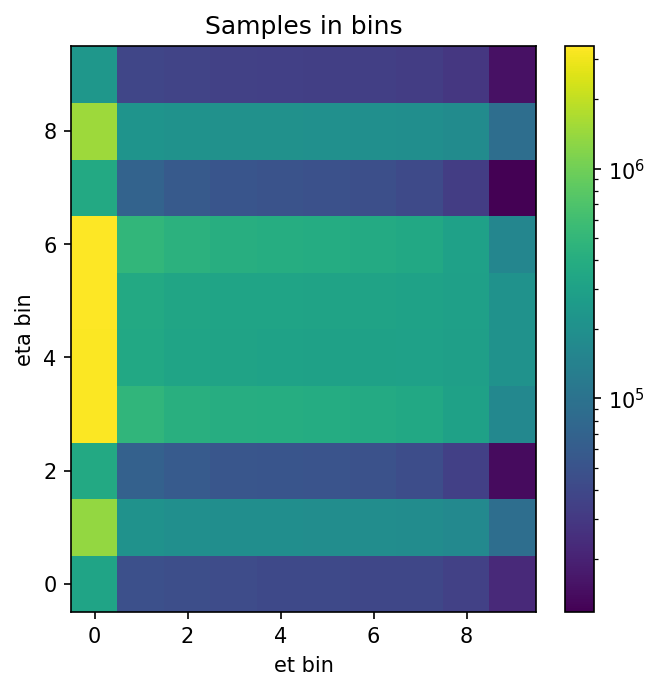

In [24]:
a = data[["et_bin", "eta_bin"]].values.T
hoccupancy = plt.hist2d(a[0], a[1], bins=[10,10], range=[(-.5,9.5),(-.5,9.5)] ,norm= colors.LogNorm())
plt.colorbar()
plt.xlabel("et bin")
plt.ylabel("eta bin")
plt.title("Samples in bins")

Text(0.5, 1.0, 'Samples in bins (out Supercluster)')

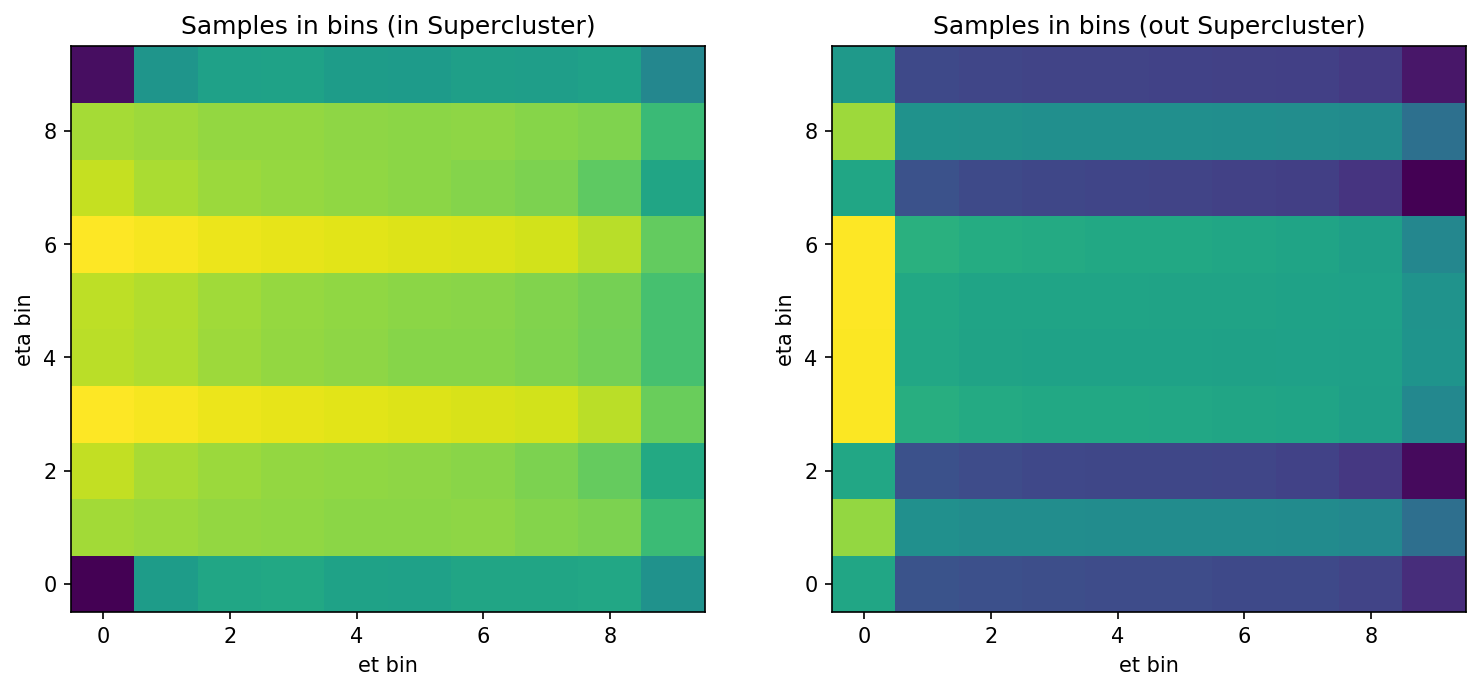

In [25]:
a_in = data[data.in_scluster==True][["et_bin", "eta_bin"]].values.T
a_out = data[data.in_scluster==False][["et_bin", "eta_bin"]].values.T
f, axs = plt.subplots(1,2, figsize=(12,5))
hoccup_in = axs[0].hist2d(a_in[0], a_in[1], bins=[10,10], range=[(-.5,9.5),(-.5,9.5)] ,norm= colors.LogNorm())
axs[0].set_xlabel("et bin")
axs[0].set_ylabel("eta bin")
axs[0].set_title("Samples in bins (in Supercluster)")

hoccup_out= axs[1].hist2d(a_out[0], a_out[1], bins=[10,10], range=[(-.5,9.5),(-.5,9.5)] ,norm= colors.LogNorm())
axs[1].set_xlabel("et bin")
axs[1].set_ylabel("eta bin")
axs[1].set_title("Samples in bins (out Supercluster)")

## Reweighting
Only the classes are reweighted, not in Et/eta bins

In [7]:
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print("Weight ",w)
data.loc[data.in_scluster,"w"] = w
data.loc[data.in_scluster==False, "w"] = 1.

Weight  16.92128773504084


# Array preparation

In [28]:
data


,calo_seed_index,cl_etaWidth,cl_f5_r9,cl_f5_sigmaIetaIeta,cl_f5_sigmaIetaIphi,cl_f5_sigmaIphiIphi,cl_f5_swissCross,cl_nxtals,cl_phiWidth,cluster_deta,...,seed_f5_swissCross,seed_iz,seed_nxtals,seed_phi,seed_phiWidth,window_index,particle,et_bin,eta_bin,w
1,-1,0.002766,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.002089,-0.016367,...,0.688010,0,3,-2.834352,0.004936,hvlerqxix,gamma,0,3,1.000000
5,2,0.002557,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001303,0.102629,...,0.238974,0,22,2.334469,0.018377,hwwsnyejt,gamma,8,3,1.000000
6,-1,0.002266,1.647160,0.009259,0.000043,0.008191,0.701537,1,0.001874,-0.158738,...,0.688010,0,3,-2.834352,0.004936,hvlerqxix,gamma,0,3,1.000000
10,2,0.002434,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001172,0.136999,...,0.238974,0,22,2.334469,0.018377,hwwsnyejt,gamma,8,3,1.000000
11,1,0.002267,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001510,0.146770,...,0.341402,0,2,-0.967447,0.001695,maaimtxxj,gamma,0,6,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34420905,2,0.002469,1.000000,0.014994,-0.000176,0.014128,0.307549,1,0.008952,-0.184024,...,0.707970,0,1,-0.480436,0.001315,isxkdovpx,electron,0,3,1.000000
34420906,1,0.002529,1.616666,0.018228,0.000150,0.017587,0.663418,1,0.001423,0.001223,...,0.112008,0,2,1.597663,0.014243,vcolwulhq,electron,1,6,16.916718
34420907,1,0.002505,1.249638,0.008355,-0.000112,0.015185,0.750362,3,0.001400,0.018357,...,0.112008,0,2,1.597663,0.014243,vcolwulhq,electron,1,6,16.916718
34420909,-1,0.002163,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.002124,-0.178211,...,1.000000,0,1,-0.864838,0.002363,lxponyheo,electron,0,4,1.000000


In [8]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
weights = data.w.values

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pickle.dump(scaler, open(model_dir + "/scaler_model_v{}_{}.pkl".format(model_version, det), "wb"))

In [27]:
scaler.mean_

array([-4.55792861e-02, -1.17083964e-02, -1.34903935e-02,  1.00161923e+02,
        2.42561384e+01, -8.63536138e-03,  4.48592224e-05,  3.45859337e+00,
        7.37630646e-01,  1.04697022e+00,  3.19432209e-02,  5.39142449e-07,
        3.79630062e-02,  4.91967698e-01,  6.15836829e+00,  3.24158995e+00,
        3.66877393e-02,  9.16334075e-05,  3.95834353e-02,  8.46881736e-01,
        1.84766712e+00])

In [28]:
scaler.scale_

array([2.19135988e+00, 1.80431643e+00, 9.99909001e-01, 1.26802617e+02,
       2.84861755e+01, 1.13600284e-01, 2.17083162e-01, 4.07726804e+00,
       1.02004000e+00, 4.79399721e-01, 1.30861530e-02, 3.85008975e-04,
       1.45566813e-02, 3.99832660e-01, 5.92165725e+00, 1.11050894e+01,
       2.14458584e-02, 6.45316467e-04, 2.24543330e-02, 3.22714857e-01,
       2.58670004e+00])

In [10]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weights, test_size=0.33)

### Some plots

(array([1112322., 2452809.,  845027.,       0.,       0.,       0.,
              0.,  828021., 2640296.,  987286.]),
 array([-2.94149637e+00, -2.35319169e+00, -1.76488700e+00, -1.17658231e+00,
        -5.88277626e-01,  2.70605087e-05,  5.88331747e-01,  1.17663643e+00,
         1.76494112e+00,  2.35324581e+00,  2.94155049e+00]),
 <a list of 10 Patch objects>)

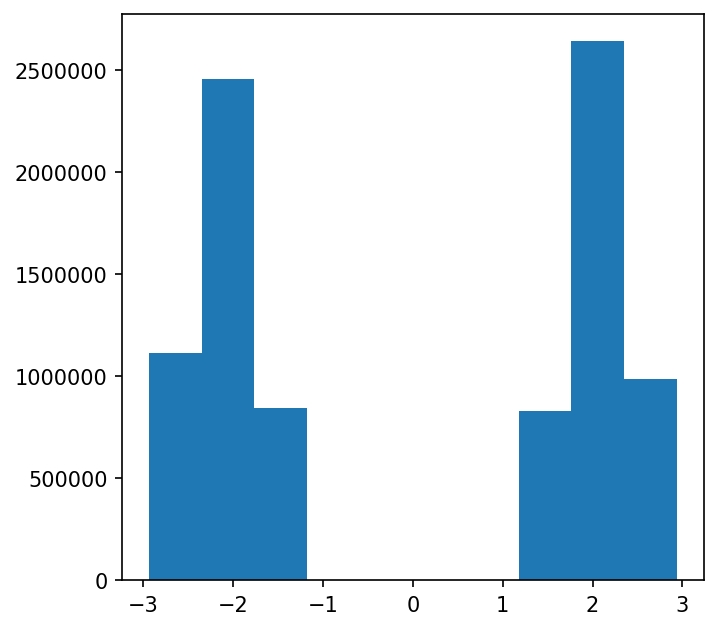

In [13]:
plt.hist(data.seed_eta)

(array([10054694.,  1954410.,   525133.,   379607.,   336347.,   315614.,
          303840.,   293251.,   283014.,   276668.,   271523.,   270633.,
          266563.,   264467.,   264640.,   261522.,   257586.,   262236.,
          259344.,   255480.,   256947.,   257496.,   254356.,   253974.,
          256085.,   251226.,   254226.,   249003.,   253469.,   250976.,
          244990.,   248582.,   247617.,   242916.,   243271.,   244615.,
          241623.,   237348.,   234008.,   234599.,   226205.,   227074.,
          220093.,   214095.,   203579.,   193947.,   181153.,   162423.,
          125662.,    52422.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <a list of 50 Patch objects

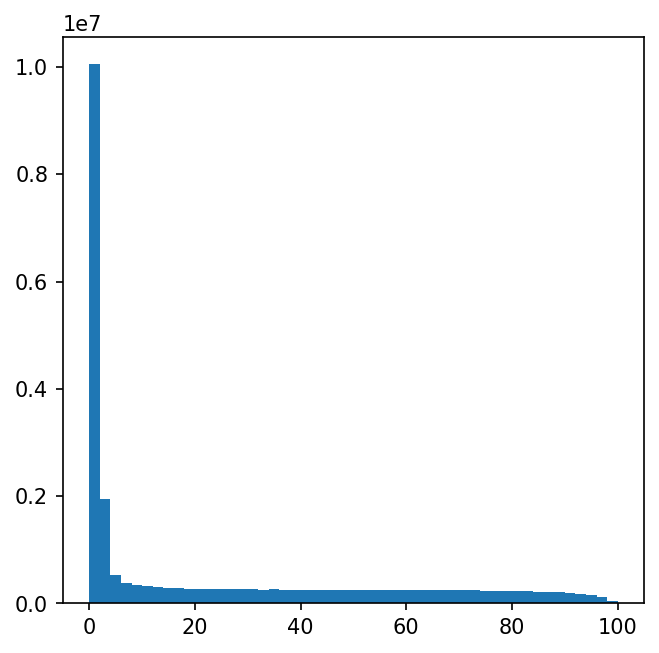

In [32]:
plt.hist(data[data.in_scluster==False].et_seed, bins=50, weights=data[data.in_scluster==False].w, range=(0,100))

# Training

In [11]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *

Using TensorFlow backend.


In [12]:
model = Sequential()
model.add(Dense(300, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(200, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))

model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               7800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

In [16]:
model = Sequential()
model.add(Dense(200, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)               

In [12]:
model = Sequential()
model.add(Dense(200, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               5200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

In [50]:
model = Sequential()
model.add(Dense(100, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               2200      
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)              

In [23]:
import math
def step_decay(epoch):
    initial_lrate = 1
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate < 0.005: return 0.005
    return lrate

In [13]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}_{}.hd5".format(model_version,det), monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=2)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=15, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save] #lr_scheduler
            )

Train on 9460462 samples, validate on 4659631 samples
Epoch 1/400
9460462/9460462 [==============================] - 49s 5us/step - loss: 0.2943 - accuracy: 0.9491 - val_loss: 0.2005 - val_accuracy: 0.9645
Epoch 2/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1952 - accuracy: 0.9571 - val_loss: 0.1775 - val_accuracy: 0.9587

Epoch 00002: val_loss improved from inf to 0.17751, saving model to ../models/v13_mustachecleaning/model_v2_EB.hd5
Epoch 3/400
9460462/9460462 [==============================] - 49s 5us/step - loss: 0.1846 - accuracy: 0.9586 - val_loss: 0.1723 - val_accuracy: 0.9605
Epoch 4/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1787 - accuracy: 0.9595 - val_loss: 0.1685 - val_accuracy: 0.9622

Epoch 00004: val_loss improved from 0.17751 to 0.16852, saving model to ../models/v13_mustachecleaning/model_v2_EB.hd5
Epoch 5/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1751 - accuracy:

9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1530 - accuracy: 0.9628 - val_loss: 0.1481 - val_accuracy: 0.9681
Epoch 44/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1530 - accuracy: 0.9629 - val_loss: 0.1491 - val_accuracy: 0.9703

Epoch 00044: val_loss did not improve from 0.14698
Epoch 45/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1529 - accuracy: 0.9628 - val_loss: 0.1465 - val_accuracy: 0.9643
Epoch 46/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1525 - accuracy: 0.9629 - val_loss: 0.1470 - val_accuracy: 0.9673

Epoch 00046: val_loss did not improve from 0.14698
Epoch 47/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1522 - accuracy: 0.9630 - val_loss: 0.1492 - val_accuracy: 0.9588
Epoch 48/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1524 - accuracy: 0.9628 - val_loss: 0.1482 - val_accuracy

9460462/9460462 [==============================] - 49s 5us/step - loss: 0.1488 - accuracy: 0.9633 - val_loss: 0.1436 - val_accuracy: 0.9637
Epoch 88/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1486 - accuracy: 0.9632 - val_loss: 0.1433 - val_accuracy: 0.9649

Epoch 00088: val_loss improved from 0.14374 to 0.14331, saving model to ../models/v13_mustachecleaning/model_v2_EB.hd5
Epoch 89/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1490 - accuracy: 0.9633 - val_loss: 0.1439 - val_accuracy: 0.9628
Epoch 90/400
9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1486 - accuracy: 0.9634 - val_loss: 0.1443 - val_accuracy: 0.9691

Epoch 00090: val_loss did not improve from 0.14331
Epoch 91/400
9460462/9460462 [==============================] - 49s 5us/step - loss: 0.1485 - accuracy: 0.9633 - val_loss: 0.1433 - val_accuracy: 0.9649
Epoch 92/400
9460462/9460462 [==============================] - 48s 5us/step

9460462/9460462 [==============================] - 48s 5us/step - loss: 0.1466 - accuracy: 0.9636 - val_loss: 0.1432 - val_accuracy: 0.9598
Epoch 00131: early stopping


In [ ]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}_{}.hd5".format(model_version,det), monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=2)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=5, verbose=1)


lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save,lr_scheduler] #lr_scheduler
            )

>>> Computing AUC...
AUC score: 0.9964866121422227
>>> Saving ROC curve...


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


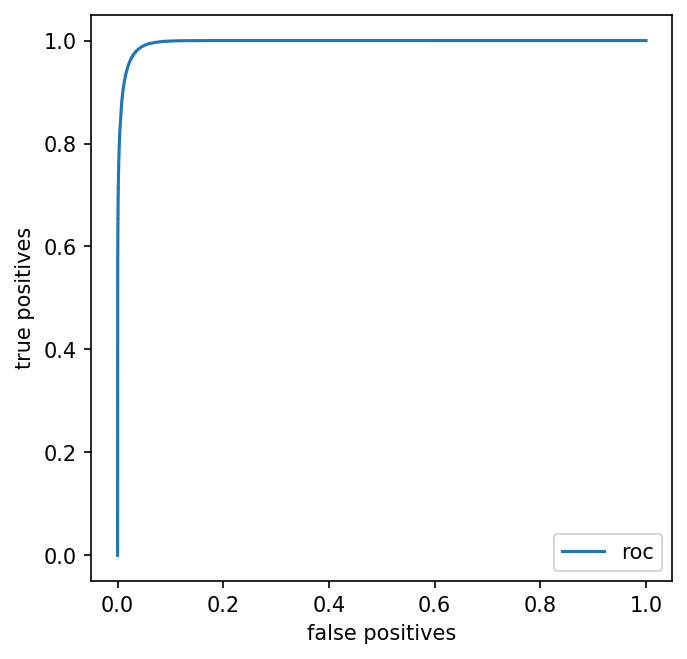

In [14]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_val,batch_size=2048)
auc = roc_auc_score(y_val, pred, sample_weight=w_val)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_val, pred, sample_weight=w_val,drop_intermediate=True)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)

plt.legend()

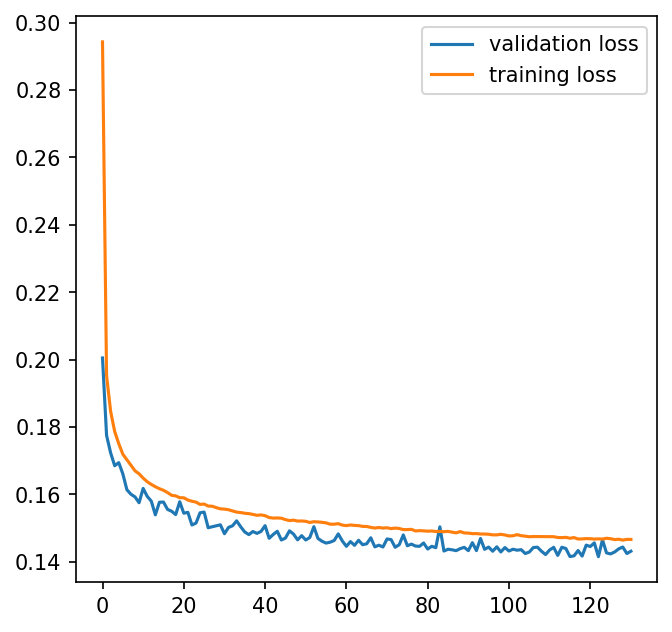

In [15]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

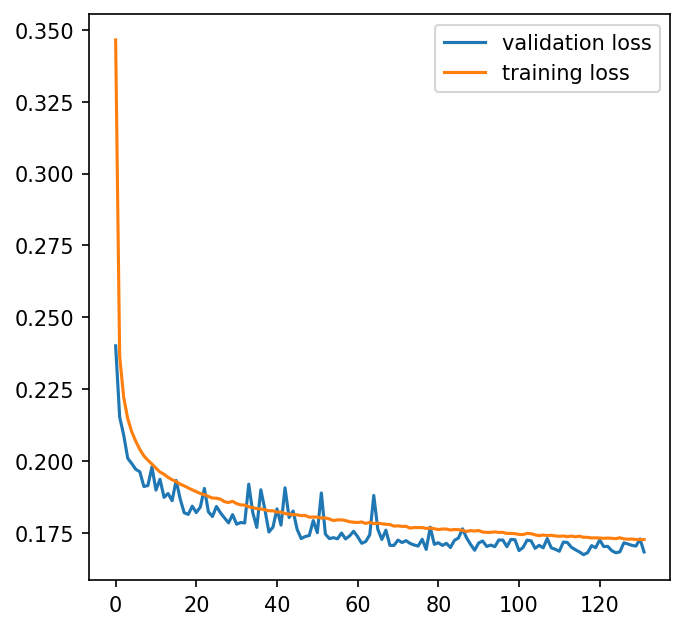

In [26]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

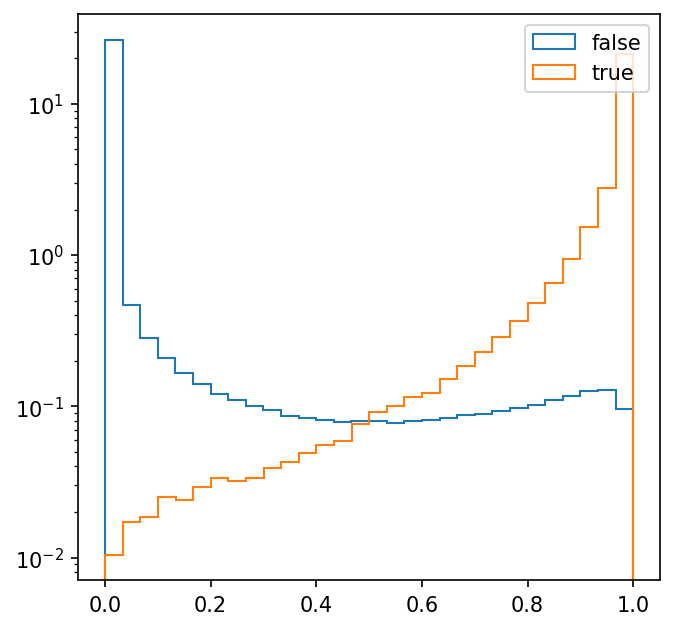

In [27]:
results = model.predict(X_val)
plt.hist(results[y_val==0], bins=30,density=True, label="false", histtype="step")
plt.hist(results[y_val==1], bins=30, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

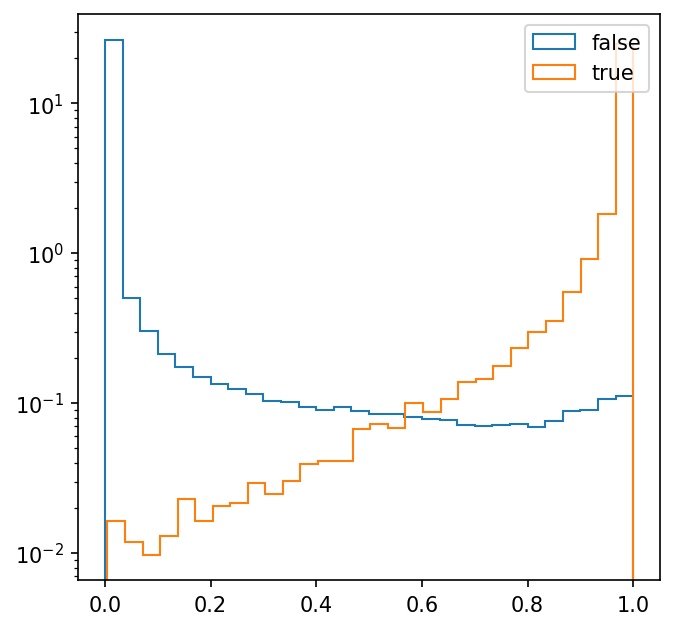

In [19]:
results = model.predict(X_val[:500000])
plt.hist(results[y_val[:500000]==0], bins=30,density=True, label="false", histtype="step")
plt.hist(results[y_val[:500000]==1], bins=30, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [31]:
plt.savefig(model_dir +"/output_model_v1_EE.png")

<Figure size 750x750 with 0 Axes>

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

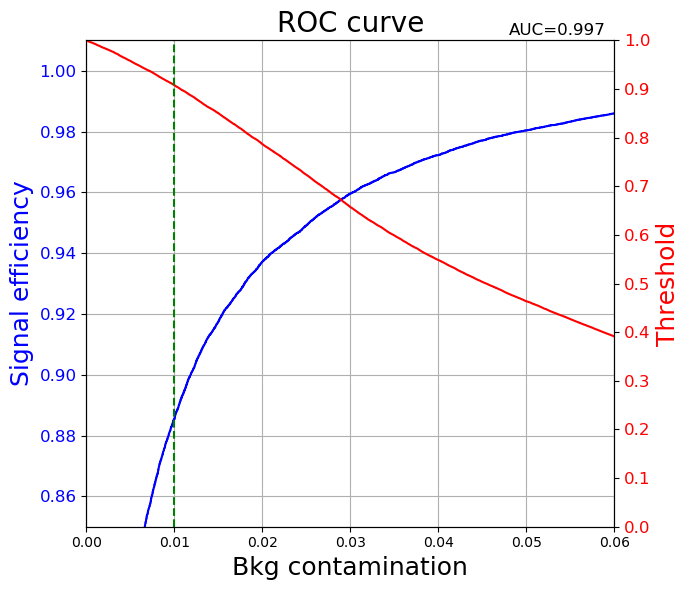

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()